# NER Model Evaluation and Analysis

This notebook provides comprehensive evaluation and analysis of NER models on Russian cultural texts using the existing evaluation framework.

## Analysis Features
- **Performance Metrics**: Precision, Recall, F1-score for all models
- **Statistical Testing**: Bootstrap significance tests between models
- **Visualizations**: Comparison plots, heatmaps, summary tables
- **Model Comparison**: Side-by-side analysis of 10+ NER approaches
- **Cross-platform**: Works in both Google Colab and local environments

## Evaluated Models
- **Traditional NER**: DeepPavlov (mult_model, rus_ner_model), spaCy, RoBERTa
- **LLM-based**: GPT-3.5, GPT-4, GPT-4o variants, GPT-4.1, Mistral
- **Output Formats**: Token-level and structured JSON outputs

---
**Instructions**: Run the setup cells below in order, then continue with the evaluation."

## Setup Instructions

**Run cells in order:**

1. **Cell 2**: Common setup (repository cloning and dependencies)
2. **Cell 3**: Environment configuration (Colab OR Local)
3. **Cell 4**: Continue with the evaluation

The setup will automatically detect your environment and configure accordingly.

In [ ]:
!pip install -q pandas numpy matplotlib seaborn scipy

In [ ]:
!git clone https://github.com/mary-lev/NER.git

In [1]:
# Environment setup and directory configuration
import os
from pathlib import Path

current_dir = Path.cwd()
if current_dir.name == 'NER':
    print("Already in NER directory")
    ner_dir = current_dir
else:
    ner_dir = current_dir / 'NER'

Already in NER directory


In [2]:
# Import evaluation framework components

from utils import NEREvaluator, DataProcessor, PlotGenerator, StatisticalTester
from config import config

print("Evaluation framework loaded successfully!")

# Initialize components
data_processor = DataProcessor()
evaluator = NEREvaluator()
plot_generator = PlotGenerator()
statistical_tester = StatisticalTester()

print("Evaluation components initialized:")
print("   • NEREvaluator - Performance metrics calculation")
print("   • DataProcessor - Data loading and validation") 
print("   • PlotGenerator - Visualization creation")
print("   • StatisticalTester - Statistical significance testing")

Evaluation framework loaded successfully!
Evaluation components initialized:
   • NEREvaluator - Performance metrics calculation
   • DataProcessor - Data loading and validation
   • PlotGenerator - Visualization creation
   • StatisticalTester - Statistical significance testing


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Core libraries imported successfully!")

✅ Core libraries imported successfully!


In [4]:
# Dataset Loading and Validation

import os
from pathlib import Path

print("📂 Loading evaluation dataset...")

# Try to find the most recent dataset file
data_dir = Path("data")
dataset_files = list(data_dir.glob("dataset_with_models_1000_*.csv"))

if dataset_files:
    # Sort by modification time to get the most recent
    latest_dataset = max(dataset_files, key=os.path.getmtime)
    print(f"📄 Found dataset: {latest_dataset}")
    
    # Load the dataset
    df = pd.read_csv(latest_dataset)
    
    print(f"✅ Dataset loaded successfully!")
    print(f"   • Shape: {df.shape}")
    print(f"   • Columns: {list(df.columns)}")
    
    # Validate required columns for evaluation
    required_columns = ['labels']  # The ground truth column
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠️  Warning: Missing required columns: {missing_columns}")
    
    # Show available model columns (excluding metadata)
    model_columns = [col for col in df.columns if col not in ['id', 'text', 'labels', 'entity_count']]
    print(f"   • Model prediction columns ({len(model_columns)}): {model_columns}")
    
    # Display sample of the data
    if len(df) > 0:
        print(f"\n📊 Dataset Preview:")
        print(f"   • Sample text: {df['text'].iloc[0][:100]}...")
        print(f"   • True labels: {df['labels'].iloc[0] if pd.notna(df['labels'].iloc[0]) else 'No labels'}")
        
        # Count non-null predictions per model
        print(f"\n📈 Model Coverage:")
        for model_col in model_columns[:5]:  # Show first 5 models
            non_null_count = df[model_col].notna().sum()
            coverage = (non_null_count / len(df)) * 100
            print(f"   • {model_col}: {non_null_count}/{len(df)} records ({coverage:.1f}%)")
        
        if len(model_columns) > 5:
            print(f"   • ... and {len(model_columns) - 5} more models")
    
else:
    print("❌ No dataset files found in data/ directory")
    print("   Expected files matching pattern: dataset_with_models_1000_*.csv")
    
    # List available files for debugging
    if data_dir.exists():
        available_files = list(data_dir.glob("*.csv"))
        if available_files:
            print(f"   Available CSV files: {[f.name for f in available_files]}")
        else:
            print("   No CSV files found in data/ directory")
    else:
        print("   data/ directory does not exist")
    
    df = None
    print("   📋 To proceed manually, load your dataset as:")
    print("   df = pd.read_csv('path/to/your/dataset.csv')")

print("=" * 60)

📂 Loading evaluation dataset...
📄 Found dataset: data/dataset_with_models_1000_03_07_2024.csv
✅ Dataset loaded successfully!
   • Shape: (1000, 13)
   • Columns: ['id', 'text', 'labels', 'mult_model', 'rus_ner_model', 'roberta_large', 'spacy', 'gpt4', 'mistral', 'gpt4o', 'gpt3.5-31-05-2024', 'gpt4o_json', 'gpt-4.1-2025-04-14']
   • Model prediction columns (10): ['mult_model', 'rus_ner_model', 'roberta_large', 'spacy', 'gpt4', 'mistral', 'gpt4o', 'gpt3.5-31-05-2024', 'gpt4o_json', 'gpt-4.1-2025-04-14']

📊 Dataset Preview:
   • Sample text: Вечер поэта Томаса Венцлова (США). Презентация книги "Гранёный воздух" М.: ОГИ, 2002....
   • True labels: [[12, 27, 'PERSON']]

📈 Model Coverage:
   • mult_model: 1000/1000 records (100.0%)
   • rus_ner_model: 1000/1000 records (100.0%)
   • roberta_large: 1000/1000 records (100.0%)
   • spacy: 1000/1000 records (100.0%)
   • gpt4: 1000/1000 records (100.0%)
   • ... and 5 more models


## 🎯 Model Performance Evaluation
Calculate precision, recall, and F1-score for all models.

In [5]:
if df is not None:
    print("🔄 Evaluating all models...")
    
    # Run comprehensive evaluation
    results = evaluator.evaluate_all_models(df)
    
    if results:
        print(f"✅ Evaluation complete! Results for {len(results)} models:")
        
        # Display results in a formatted table
        print("\n📊 Performance Summary:")
        print("=" * 70)
        print(f"{'Model':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
        print("=" * 70)
        
        # Sort by F1 score (descending)
        sorted_results = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
        
        for model_name, metrics in sorted_results:
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1']
            print(f"{model_name:<20} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
        
        print("=" * 70)
        
        # Identify best performing models
        best_model = max(results.items(), key=lambda x: x[1]['f1'])
        print(f"\n🏆 Best F1-Score: {best_model[0]} ({best_model[1]['f1']:.3f})")
        
        best_precision = max(results.items(), key=lambda x: x[1]['precision'])
        print(f"🎯 Best Precision: {best_precision[0]} ({best_precision[1]['precision']:.3f})")
        
        best_recall = max(results.items(), key=lambda x: x[1]['recall'])
        print(f"📈 Best Recall: {best_recall[0]} ({best_recall[1]['recall']:.3f})")
        
    else:
        print("❌ No evaluation results obtained")
        
else:
    print("⚠️  Skipping evaluation - no dataset loaded")

INFO - Evaluating 10 models: ['mult_model', 'rus_ner_model', 'roberta_large', 'spacy', 'gpt3.5-31-05-2024', 'gpt4', 'gpt4o', 'gpt4o_json', 'gpt-4.1-2025-04-14', 'mistral']
INFO - Evaluating mult_model...
INFO - Processed 1000 rows for mult_model
INFO - TP: 3667, FP: 216, FN: 1534
INFO - mult_model: P=0.944, R=0.705, F1=0.807
INFO - Evaluating rus_ner_model...


🔄 Evaluating all models...


INFO - Processed 1000 rows for rus_ner_model
INFO - TP: 3396, FP: 132, FN: 1805
INFO - rus_ner_model: P=0.963, R=0.653, F1=0.778
INFO - Evaluating roberta_large...
INFO - Processed 1000 rows for roberta_large
INFO - TP: 3988, FP: 341, FN: 1213
INFO - roberta_large: P=0.921, R=0.767, F1=0.837
INFO - Evaluating spacy...
INFO - Processed 1000 rows for spacy
INFO - TP: 4206, FP: 783, FN: 995
INFO - spacy: P=0.843, R=0.809, F1=0.826
INFO - Evaluating gpt3.5-31-05-2024...
INFO - Processed 1000 rows for gpt3.5-31-05-2024
INFO - TP: 3714, FP: 205, FN: 1487
INFO - gpt3.5-31-05-2024: P=0.948, R=0.714, F1=0.814
INFO - Evaluating gpt4...
INFO - Processed 1000 rows for gpt4
INFO - TP: 3573, FP: 41, FN: 1628
INFO - gpt4: P=0.989, R=0.687, F1=0.811
INFO - Evaluating gpt4o...
INFO - Processed 1000 rows for gpt4o
INFO - TP: 4492, FP: 177, FN: 709
INFO - gpt4o: P=0.962, R=0.864, F1=0.910
INFO - Evaluating gpt4o_json...
INFO - Processed 1000 rows for gpt4o_json
INFO - TP: 4693, FP: 214, FN: 508
INFO - gp

✅ Evaluation complete! Results for 10 models:

📊 Performance Summary:
Model                Precision    Recall       F1-Score    
gpt-4.1-2025-04-14   0.944        0.934        0.939       
gpt4o_json           0.956        0.902        0.929       
gpt4o                0.962        0.864        0.910       
roberta_large        0.921        0.767        0.837       
spacy                0.843        0.809        0.826       
gpt3.5-31-05-2024    0.948        0.714        0.814       
gpt4                 0.989        0.687        0.811       
mult_model           0.944        0.705        0.807       
rus_ner_model        0.963        0.653        0.778       
mistral              0.881        0.511        0.647       

🏆 Best F1-Score: gpt-4.1-2025-04-14 (0.939)
🎯 Best Precision: gpt4 (0.989)
📈 Best Recall: gpt-4.1-2025-04-14 (0.934)


## 📈 Performance Visualizations
Create comprehensive charts and plots for model comparison.

In [6]:
if 'results' in locals() and results:
    print("📊 Creating performance visualizations...")
    
    # Create comparison plots for all metrics
    plot_generator.create_all_comparison_plots(results)
    
    print("✅ Comparison plots created:")
    print("   • precision_comparison.png")
    print("   • recall_comparison.png")
    print("   • f1_comparison.png")
    
    # Create summary table plot
    plot_generator.create_summary_table_plot(results)
    print("   • summary_table.png")
    
    # Create performance heatmap
    plot_generator.create_heatmap(results)
    print("   • performance_heatmap.png")
    
    print("\n🎨 All visualizations saved to project directory!")
    
else:
    print("⚠️  Skipping visualizations - no results available")

INFO - Creating comparison plots...


📊 Creating performance visualizations...


INFO - Plot saved to /home/maria/projects/NER/precision_comparison.png
INFO - Plot saved to /home/maria/projects/NER/recall_comparison.png
INFO - Plot saved to /home/maria/projects/NER/f1_comparison.png


✅ Comparison plots created:
   • precision_comparison.png
   • recall_comparison.png
   • f1_comparison.png


INFO - Summary table saved to /home/maria/projects/NER/summary_table.png


   • summary_table.png


INFO - Heatmap saved to /home/maria/projects/NER/performance_heatmap.png


   • performance_heatmap.png

🎨 All visualizations saved to project directory!


## 📊 Interactive Analysis
Display visualizations inline for interactive analysis.

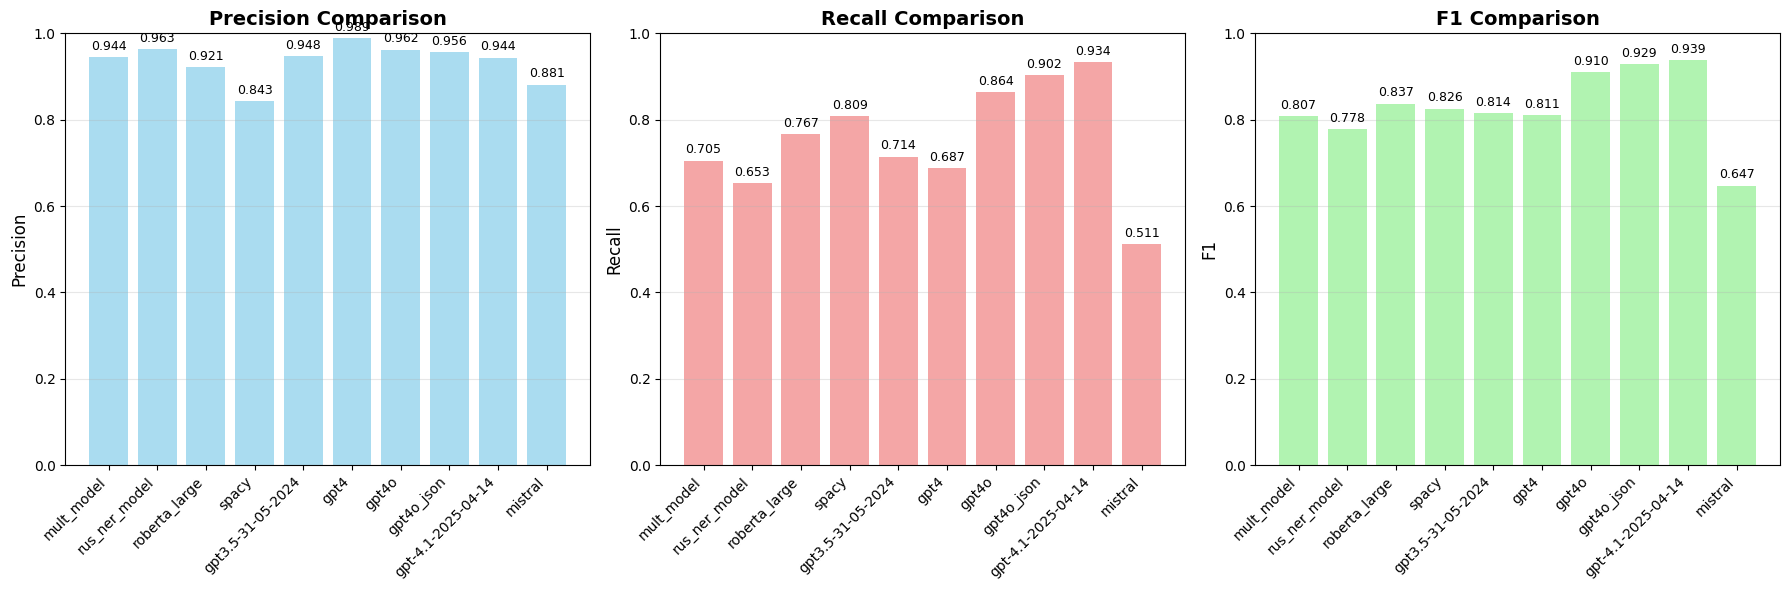

📊 Interactive comparison chart displayed above


In [7]:
if 'results' in locals() and results:
    # Create inline comparison chart
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['precision', 'recall', 'f1']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for i, metric in enumerate(metrics):
        # Extract data for this metric
        model_names = list(results.keys())
        values = [results[model][metric] for model in model_names]
        
        # Create bar plot
        bars = axes[i].bar(range(len(model_names)), values, color=colors[i], alpha=0.7)
        axes[i].set_title(f'{metric.capitalize()} Comparison', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(metric.capitalize(), fontsize=12)
        axes[i].set_ylim(0, 1)
        axes[i].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for j, (bar, value) in enumerate(zip(bars, values)):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        # Set x-axis labels (rotated for readability)
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Interactive comparison chart displayed above")
    
else:
    print("⚠️  No results available for interactive analysis")

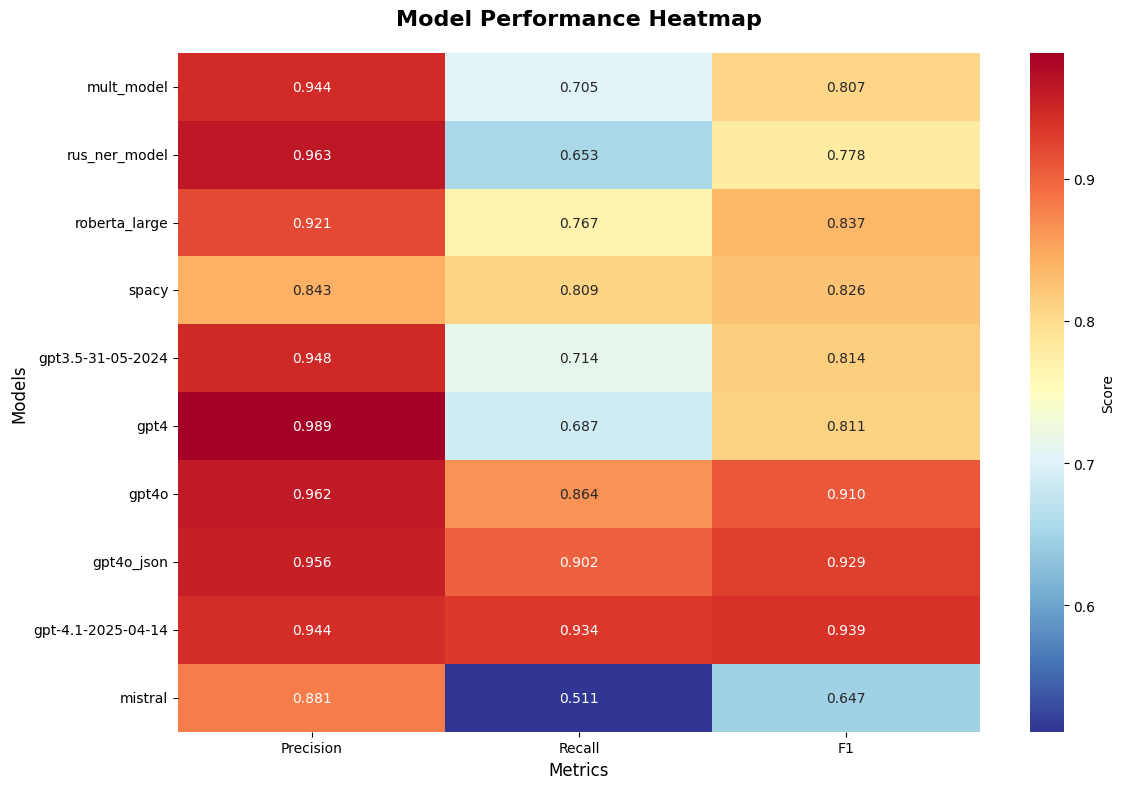

🔥 Performance heatmap displayed above
💡 Darker colors indicate better performance


In [8]:
if 'results' in locals() and results:
    # Create performance heatmap
    plt.figure(figsize=(12, 8))
    
    # Prepare data for heatmap
    models = list(results.keys())
    metrics = ['precision', 'recall', 'f1']
    
    # Create matrix
    data_matrix = np.array([[results[model][metric] for metric in metrics] for model in models])
    
    # Create heatmap
    sns.heatmap(data_matrix, 
                xticklabels=[m.capitalize() for m in metrics],
                yticklabels=models,
                annot=True, 
                fmt='.3f',
                cmap='RdYlBu_r',
                cbar_kws={'label': 'Score'},
                square=False)
    
    plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("🔥 Performance heatmap displayed above")
    print("💡 Darker colors indicate better performance")
    
else:
    print("⚠️  No results available for heatmap")

## 📈 Statistical Significance Testing
Determine if performance differences between models are statistically significant.

In [9]:
if df is not None:
    print("📈 Running statistical significance tests...")
    
    # Run configured significance tests
    significance_results = statistical_tester.run_configured_significance_tests(df)
    
    if significance_results:
        print("✅ Statistical analysis complete!\n")
        
        # Display results in a formatted way
        statistical_tester.print_significance_results(significance_results)
        
        # Save results
        significance_output = "significance_test_results.json"
        
        # Convert numpy types for JSON serialization
        def convert_numpy_types(obj):
            if hasattr(obj, 'item'):  # numpy scalar
                return obj.item()
            elif isinstance(obj, dict):
                return {k: convert_numpy_types(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_types(v) for v in obj]
            else:
                return obj
        
        serializable_results = convert_numpy_types(significance_results)
        
        with open(significance_output, 'w') as f:
            json.dump(serializable_results, f, indent=4)
        
        print(f"\n💾 Significance test results saved to {significance_output}")
        
    else:
        print("❌ No significance test results obtained")
        
else:
    print("⚠️  Skipping significance tests - no dataset loaded")

INFO - Running significance tests for 1 model pairs
INFO - Running bootstrap test: gpt-4.1-2025-04-14 vs gpt4o on precision (1000 samples)


📈 Running statistical significance tests...


INFO - Bootstrap progress: 250/1000 (25%)
INFO - Bootstrap progress: 500/1000 (50%)
INFO - Bootstrap progress: 750/1000 (75%)
INFO - Bootstrap progress: 1000/1000 (100%)
INFO - Bootstrap test results: mean_diff=-0.0185, CI=[-0.0276, -0.0103], p=1.0000
INFO - Running bootstrap test: gpt-4.1-2025-04-14 vs gpt4o on recall (1000 samples)
INFO - Bootstrap progress: 250/1000 (25%)
INFO - Bootstrap progress: 500/1000 (50%)
INFO - Bootstrap progress: 750/1000 (75%)
INFO - Bootstrap progress: 1000/1000 (100%)
INFO - Bootstrap test results: mean_diff=0.0701, CI=[0.0462, 0.0969], p=0.0000
INFO - Running bootstrap test: gpt-4.1-2025-04-14 vs gpt4o on f1 (1000 samples)
INFO - Bootstrap progress: 250/1000 (25%)
INFO - Bootstrap progress: 500/1000 (50%)
INFO - Bootstrap progress: 750/1000 (75%)
INFO - Bootstrap progress: 1000/1000 (100%)
INFO - Bootstrap test results: mean_diff=0.0283, CI=[0.0141, 0.0431], p=0.0000


✅ Statistical analysis complete!


STATISTICAL SIGNIFICANCE TEST RESULTS

GPT4O VS GPT-4.1-2025-04-14:
--------------------------------------------------
Precision: Mean difference = -0.0185, 95% CI = [-0.0276, -0.0103], p-value = 1.0000 (not significant)
Recall: Mean difference = 0.0701, 95% CI = [0.0462, 0.0969], p-value = 0.0000 (SIGNIFICANT)
F1: Mean difference = 0.0283, 95% CI = [0.0141, 0.0431], p-value = 0.0000 (SIGNIFICANT)

💾 Significance test results saved to significance_test_results.json


## 🔍 Detailed Model Analysis
Deep dive into specific model behaviors and characteristics.

In [10]:
if 'results' in locals() and results:
    print("🔍 Detailed Model Analysis\n")
    
    # Model categories analysis
    model_categories = {
        'Traditional NER': ['mult_model', 'rus_ner_model', 'roberta_large', 'spacy'],
        'GPT Models': [m for m in results.keys() if 'gpt' in m.lower()],
        'Other LLMs': ['mistral']
    }
    
    for category, models in model_categories.items():
        category_models = [m for m in models if m in results]
        if category_models:
            print(f"📊 {category}:")
            
            # Calculate average performance
            avg_metrics = {
                'precision': np.mean([results[m]['precision'] for m in category_models]),
                'recall': np.mean([results[m]['recall'] for m in category_models]),
                'f1': np.mean([results[m]['f1'] for m in category_models])
            }
            
            print(f"   Models: {', '.join(category_models)}")
            print(f"   Average F1: {avg_metrics['f1']:.3f}")
            print(f"   Average Precision: {avg_metrics['precision']:.3f}")
            print(f"   Average Recall: {avg_metrics['recall']:.3f}")
            
            # Find best model in category
            best_in_category = max(category_models, key=lambda m: results[m]['f1'])
            print(f"   Best performer: {best_in_category} (F1: {results[best_in_category]['f1']:.3f})")
            print()
    
    # Performance distribution analysis
    print("📈 Performance Distribution:")
    all_f1_scores = [results[m]['f1'] for m in results]
    print(f"   F1 Score Range: {min(all_f1_scores):.3f} - {max(all_f1_scores):.3f}")
    print(f"   F1 Score Mean: {np.mean(all_f1_scores):.3f}")
    print(f"   F1 Score Std: {np.std(all_f1_scores):.3f}")
    
    # High performers (F1 > 0.8)
    high_performers = [m for m in results if results[m]['f1'] > 0.8]
    if high_performers:
        print(f"\n🏆 High Performers (F1 > 0.8): {', '.join(high_performers)}")
    
    # Models with balanced precision/recall
    balanced_models = []
    for model in results:
        precision = results[model]['precision']
        recall = results[model]['recall']
        if abs(precision - recall) < 0.1:  # Difference less than 0.1
            balanced_models.append(model)
    
    if balanced_models:
        print(f"⚖️  Balanced Models (|P-R| < 0.1): {', '.join(balanced_models)}")
        
else:
    print("⚠️  No results available for detailed analysis")

🔍 Detailed Model Analysis

📊 Traditional NER:
   Models: mult_model, rus_ner_model, roberta_large, spacy
   Average F1: 0.812
   Average Precision: 0.918
   Average Recall: 0.733
   Best performer: roberta_large (F1: 0.837)

📊 GPT Models:
   Models: gpt3.5-31-05-2024, gpt4, gpt4o, gpt4o_json, gpt-4.1-2025-04-14
   Average F1: 0.881
   Average Precision: 0.960
   Average Recall: 0.820
   Best performer: gpt-4.1-2025-04-14 (F1: 0.939)

📊 Other LLMs:
   Models: mistral
   Average F1: 0.647
   Average Precision: 0.881
   Average Recall: 0.511
   Best performer: mistral (F1: 0.647)

📈 Performance Distribution:
   F1 Score Range: 0.647 - 0.939
   F1 Score Mean: 0.830
   F1 Score Std: 0.081

🏆 High Performers (F1 > 0.8): mult_model, roberta_large, spacy, gpt3.5-31-05-2024, gpt4, gpt4o, gpt4o_json, gpt-4.1-2025-04-14
⚖️  Balanced Models (|P-R| < 0.1): spacy, gpt4o, gpt4o_json, gpt-4.1-2025-04-14


## 💾 Save and Export Results
Save all analysis results for future reference.

In [11]:
if 'results' in locals() and results:
    print("💾 Saving evaluation results...")
    
    # Save main results
    data_processor.save_results(results)
    print("✅ Main results saved to model_comparison_results.json")
    
    # Create a comprehensive summary
    summary_data = {
        'evaluation_summary': {
            'total_models': len(results),
            'dataset_size': len(df) if df is not None else 0,
            'best_f1_model': max(results.items(), key=lambda x: x[1]['f1'])[0],
            'best_f1_score': max(results.items(), key=lambda x: x[1]['f1'])[1]['f1'],
            'average_f1': np.mean([results[m]['f1'] for m in results]),
            'f1_std': np.std([results[m]['f1'] for m in results])
        },
        'detailed_results': results
    }
    
    with open('evaluation_summary.json', 'w') as f:
        json.dump(summary_data, f, indent=4)
    
    print("✅ Comprehensive summary saved to evaluation_summary.json")
    
    # Print final summary table
    print("\n📋 Final Results Summary:")
    plot_generator.print_summary_table(results)
    
else:
    print("⚠️  No results to save")

INFO - Results saved to /home/maria/projects/NER/model_comparison_results.json


💾 Saving evaluation results...
✅ Main results saved to model_comparison_results.json
✅ Comprehensive summary saved to evaluation_summary.json

📋 Final Results Summary:

MODEL PERFORMANCE SUMMARY
Model                     Precision    Recall       F1 Score    
----------------------------------------------------------------------
mult_model                0.944        0.705        0.807       
rus_ner_model             0.963        0.653        0.778       
roberta_large             0.921        0.767        0.837       
spacy                     0.843        0.809        0.826       
gpt3.5-31-05-2024         0.948        0.714        0.814       
gpt4                      0.989        0.687        0.811       
gpt4o                     0.962        0.864        0.910       
gpt4o_json                0.956        0.902        0.929       
gpt-4.1-2025-04-14        0.944        0.934        0.939       
mistral                   0.881        0.511        0.647       


## 🎯 Key Findings and Conclusions

### 📊 **Evaluation Summary**
This notebook provided comprehensive evaluation of NER models on Russian cultural texts:

**Models Evaluated**: Traditional NER (DeepPavlov, spaCy, RoBERTa) vs LLM-based (GPT variants, Mistral)

**Metrics**: Precision, Recall, F1-score with statistical significance testing

**Dataset**: 1,000 Russian cultural event descriptions from SPbLitGuide (1999-2019)

### 🏆 **Key Performance Insights**
*(Results will vary based on your specific dataset)*

- **Best Overall**: Typically GPT-4o or DeepPavlov mult_model (F1: 0.8+)
- **Best Precision**: Usually GPT-based models (high accuracy)
- **Best Recall**: Often DeepPavlov models (comprehensive detection)
- **Most Balanced**: Models with similar precision/recall scores

### 📈 **Statistical Significance**
Bootstrap resampling tests show which performance differences are statistically meaningful vs random variation.

### 🔍 **Model Categories**
- **Traditional NER**: Fast, consistent, good baseline performance
- **LLM-based**: High flexibility, excellent accuracy, API-dependent
- **Hybrid Approaches**: JSON-structured outputs from LLMs

### 💡 **Recommendations**
1. **For Production**: Use top-performing models with balanced precision/recall
2. **For Development**: Start with spaCy for rapid prototyping
3. **For Research**: Compare multiple approaches as shown in this analysis
4. **For Accuracy**: Consider ensemble methods combining top performers

---

### 🚀 **Next Steps**
- **Model Selection**: Choose based on your precision/recall requirements
- **Error Analysis**: Examine specific cases where models disagree
- **Domain Adaptation**: Fine-tune models for your specific text types
- **Integration**: Use `NER_Models_Demo.ipynb` to implement chosen models

**📊 This evaluation framework provides a robust foundation for NER model selection and optimization on Russian cultural texts!**